In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyrealsense2 as rs
import cv2

## Konfiguracja kamery Intel Real Sense 435D

In [2]:
pipeline = rs.pipeline()
config = rs.config()

pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))

found_rgb = False
for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        break
if not found_rgb:
    print("The demo requires Depth camera with Color sensor")
    #exit(0)

config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

pipeline.start(config)

## Dodanie modeli do segmentacji

In [3]:
import torch
from torchvision import transforms
from ultralytics import YOLO
from ultralytics import SAM


models_torch = []

models_torch.append(torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True))
models_torch.append(torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True))
models_torch.append(torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True))

models_YOLO = []

models_YOLO.append(YOLO('yolov8l-seg.pt'))
models_YOLO.append(YOLO('yolov8n-seg.pt'))
models_YOLO.append(YOLO('yolov9c-seg.pt'))
models_YOLO.append(YOLO('yolov9e-seg.pt'))
# models_YOLO.append(SAM('sam_b.pt'))
# models_YOLO.append(SAM('sam_l.pt'))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

for model in models_torch:
    model.to(device)

for model in models_YOLO:
    model.to(device)

Using cache found in /home/mikolaj/.cache/torch/hub/pytorch_vision_v0.10.0
/home/mikolaj/anaconda3/envs/inz/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mikolaj/anaconda3/envs/inz/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /home/mikolaj/.cache/torch/hub/pytorch_vision_v0.10.0
/home/mikolaj/anaconda3/envs/inz/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` 

Using device: cpu



0: 480x640 1 person, 1 chair, 738.5ms
Speed: 31.2ms preprocess, 738.5ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 chair, 78.4ms
Speed: 1.2ms preprocess, 78.4ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 chair, 1 bed, 1 tv, 434.7ms
Speed: 1.4ms preprocess, 434.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 chairs, 1 bed, 827.6ms
Speed: 1.4ms preprocess, 827.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)
(5, 2)


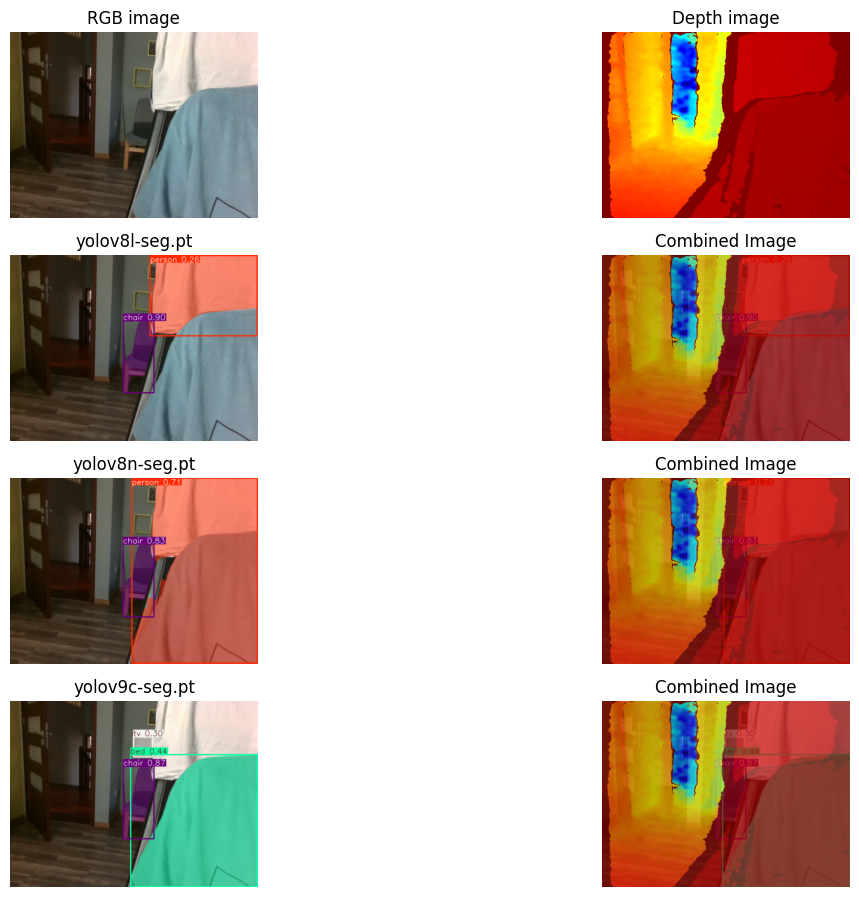

In [4]:
try:
    while True:
            for i in range(50): #kamera na początku pokazuje obraz w odcieniach niebieskich. Z czasem kolory poprawiają swoją barwę
                # Wait for a coherent pair of frames: depth and color
                frames = pipeline.wait_for_frames()
                depth_frame = frames.get_depth_frame()
                color_frame = frames.get_color_frame()
                if not depth_frame or not color_frame:
                    continue

                # Convert images to numpy arrays
                depth_image = np.asanyarray(depth_frame.get_data())
                color_image = np.asanyarray(color_frame.get_data())
                color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)

                # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
                depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.033), cv2.COLORMAP_JET)

                depth_colormap_dim = depth_colormap.shape
                color_colormap_dim = color_image.shape

                # If depth and color resolutions are different, resize color image to match depth image for display
                if depth_colormap_dim != color_colormap_dim:
                    resized_color_image = cv2.resize(color_image, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
                    #images = np.hstack((resized_color_image, depth_colormap))
                #else:
                    #images = np.hstack((color_image, depth_colormap))


            #MARK: Segmentacja semantyczna
            preprocess = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

            preprocess = preprocess(color_image)
            preprocess = preprocess.to(device)
            preprocess = preprocess.unsqueeze(0)

            # segmented_images = []
            # for model in models_torch:
            #     with torch.no_grad():
            #         output = model(preprocess)['out'][0]
            #         segmented_images.append(output.argmax(0))

            device = "0" if torch.cuda.is_available() else "cpu"
            if device == "0":
                torch.cuda.set_device(0)

            segmented_images_by_yolo = []
            for model in models_YOLO:

                output = model(color_image)
                segmented_images_by_yolo.append(output)
            

            output_greed_size = (int(len(segmented_images_by_yolo))+1,2)
            print(output_greed_size)

            plt.figure(figsize=(14, 14))

            plt.subplot(output_greed_size[0], output_greed_size[1], 1)
            plt.imshow(color_image)
            plt.title('RGB image')
            plt.axis('off')


            plt.subplot(output_greed_size[0], output_greed_size[1], 2)
            plt.imshow(depth_colormap)
            plt.title('Depth image')
            plt.axis('off')


            for i in range(int(len(segmented_images_by_yolo)/2)+1):
                plt.subplot(output_greed_size[0], output_greed_size[1], 3+2*i)
                plt.imshow(segmented_images_by_yolo[i][0].plot())
                plt.title(f'{models_YOLO[i].model_name}')
                plt.axis('off')



                #Combine depth and segmented image

                combined_image = cv2.addWeighted(depth_colormap, 0.7, segmented_images_by_yolo[i][0].plot(), 0.3, 0)
                plt.subplot(output_greed_size[0], output_greed_size[1], 3+2*i+1)
                plt.imshow(combined_image)
                plt.title('Combined Image')
                plt.axis('off')


            plt.show()


            #połączenie chmury punktów na obraz

            # Combine depth point cloud with segmented image

            break
finally:
    #pipeline.stop()
    pass
